<a href="https://colab.research.google.com/github/hirajya/Mask-Type-Classification-using-CNN/blob/main/Mask_Type_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask Type Classification using CNN
Classification model for mask types (cloth, n95, n95v, nfm, srg)

- cloth --> Cloth face mask images
- n95 --> N95 face mask images
- n95v --> N95 with Valve face mask images
- nfm --> No Face Mask images
- srg --> Surgical face mask images

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 300
BATCH_SIZE = 32
CHANNELS = 5
EPOCHS= 50

In [4]:
path_directory = '/content/drive/MyDrive/mask_types_ds'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_directory,
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1411 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
class_names

['cloth', 'n95', 'n95v', 'nfm', 'srg']

In [6]:
len(dataset)

45

In [7]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 300, 300, 3)
[0 3 3 0 1 1 2 1 2 1 0 0 0 1 0 2 2 2 1 0 0 1 0 2 2 0 2 0 2 1 1 1]


In [8]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].shape)


(300, 300, 3)


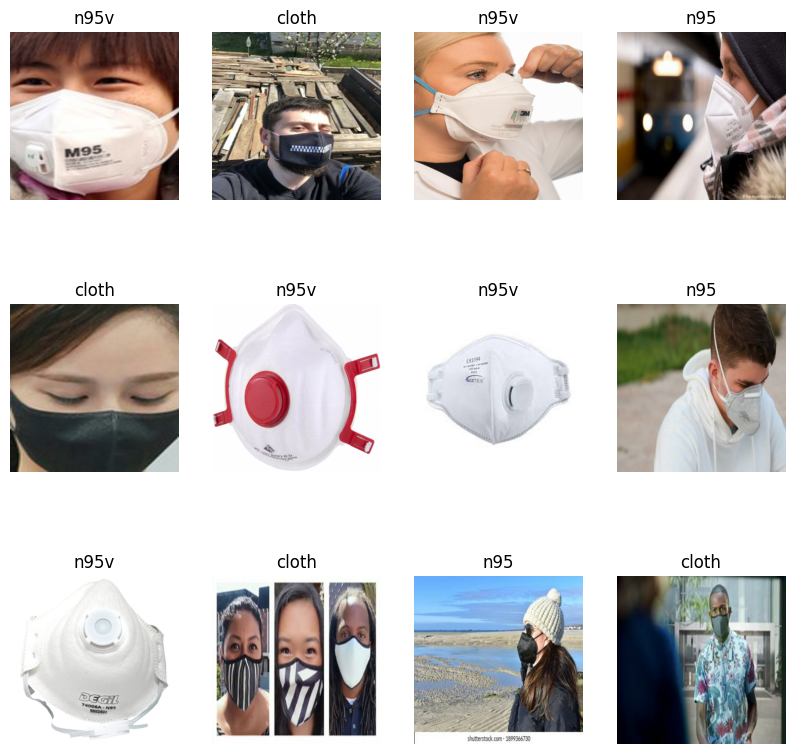

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

Splitting for training, validation, & testing

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds


In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

36

In [19]:
len(val_ds)

4

In [20]:
len(test_ds)

5

Optimizing performance

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Scaling the dataset

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/300)
])

Using data augmentation in the dataset

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])